# В этом файле мы восстанавливаем 3d координаты из 2d с помощью уравнения плоскости

In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

### Достанем результат калибровки:

In [2]:
import pickle
f = open("data_of_calibrate_camera.pckl", "rb")
ret = pickle.load(f)
mtx = pickle.load(f)
dist = pickle.load(f)
rvecs = pickle.load(f)
tvecs = pickle.load(f)

### Вытащим картинку для калибровки + undistord её

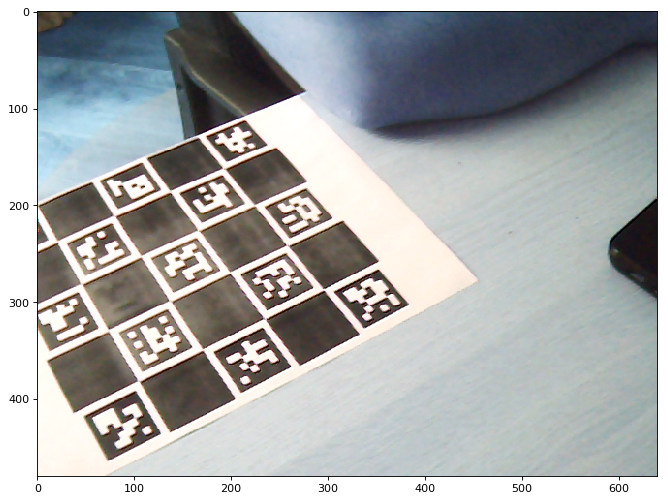

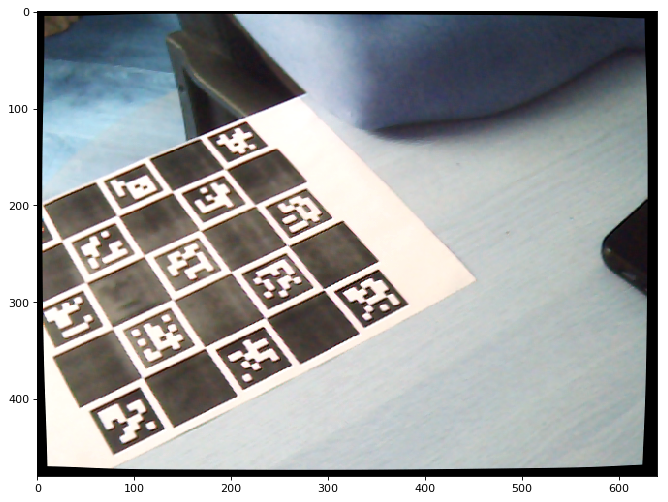

In [3]:
frame = cv2.imread('./../data/test_coordinates/real_coordinates.png')
#print(os.getcwd())
#print(frame)
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(frame, interpolation = "nearest")
frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(frame, interpolation = "nearest")
plt.show()

In [4]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
    
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

#corners

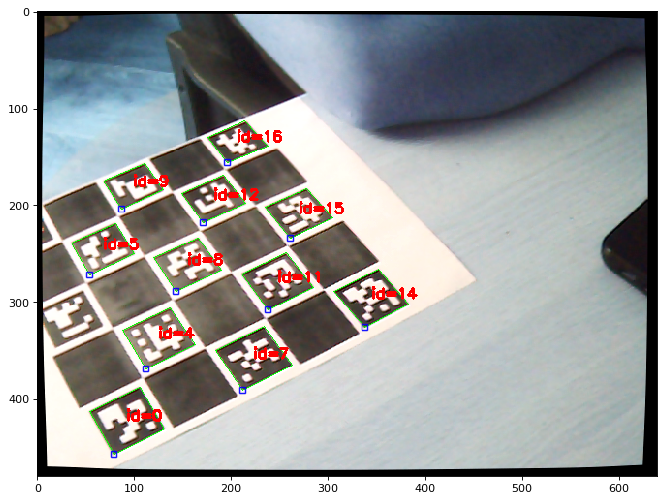

In [5]:
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Получим информацию о маркерах с калибровочной доски для задания плоскости

In [6]:
size_of_marker =  0.0285 # side lenght of the marker in meter
rvecs,tvecs,_objPoints  = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
print(tvecs)

[[[ 0.00922013  0.02342506  0.37863069]]

 [[-0.07658817 -0.07369071  0.4679236 ]]

 [[-0.12091797  0.08791677  0.38489434]]

 [[-0.05191442  0.05342847  0.3713561 ]]

 [[-0.10770751  0.0459721   0.39705221]]

 [[-0.04194685  0.01477436  0.38933712]]

 [[-0.09654319  0.00571684  0.41531465]]

 [[-0.15357569 -0.00374991  0.4395323 ]]

 [[-0.03209491 -0.02378617  0.41089377]]

 [[-0.08576757 -0.03378969  0.43695894]]

 [[-0.14192018 -0.04413054  0.46149366]]]


In [7]:
print(ids.flatten())

[14 16  0  7  4 11  8  5 15 12  9]


In [8]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data
#print(data.loc[0:1].values[0])

,tx,ty,tz
marker,,,
0,-0.120918,0.087917,0.384894
4,-0.107708,0.045972,0.397052
5,-0.153576,-0.003750,0.439532
7,-0.051914,0.053428,0.371356
8,-0.096543,0.005717,0.415315
9,-0.141920,-0.044131,0.461494
11,-0.041947,0.014774,0.389337
12,-0.085768,-0.033790,0.436959
14,0.009220,0.023425,0.378631


## Получим уравнение плоскости
#### (тут надо переписать, чтобы не выбирать точки на одной прямой)
https://ege-ok.ru/2012/03/18/uravnenie-ploskosti

In [9]:
mat_plane_solve = [None]*len(tvecs-2)
mat_plane_solve = np.array(mat_plane_solve)
mat_plane_end = [0.]*3 #говнокод, но работает
mat_plane_end = np.array(mat_plane_end) # среднее значение коэфф уравнения плоскости

# строкой ниже надо len(tvecs)-2, сделал иначе, тк точки на прямой получились.

for i in range(len(tvecs)-2):
    if (i != 5 and i!=8): #выкинули неверные уравнения, тк точки на одной прямой
        mat_plane_a = np.array([tvecs[i][0],tvecs[i+1][0],tvecs[i+2][0]])
        mat_plane_b = np.array([[-1],[-1],[-1]])
        mat_plane_solve[i] = np.linalg.solve(mat_plane_a,mat_plane_b)
        #print("i = ", i)
        #print(mat_plane_solve[i])
        for j in range(3):
            mat_plane_end[j] += float(mat_plane_solve[i][j][0])/(len(tvecs)-2)
            #print(float(mat_plane_solve[i][j][0])/float(mat_plane_solve[i][0][0]))
print(mat_plane_solve)

[array([[-0.88442836],
       [-1.53952207],
       [-2.52431218]])
 array([[-1.38419519],
       [-1.73440558],
       [-2.63680348]])
 array([[-1.08626555],
       [-1.11996083],
       [-2.68355644]])
 array([[-1.00943171],
       [-1.47956428],
       [-2.62107774]])
 array([[-1.00362451],
       [-1.4673637 ],
       [-2.62091506]]) None
 array([[-0.8530148 ],
       [-1.47591303],
       [-2.58578695]])
 array([[-0.92269028],
       [-1.85889121],
       [-2.61339947]]) None
 None None]


In [10]:
print(mat_plane_end) # среднее значение коэфф уравнения плоскости

[-0.79373893 -1.18618008 -2.03176126]


## Далее получим 2d координаты точки из 3d:

In [11]:
def test_find_3d_from_2d(i):
    #print(tvecs[0][0])
    x_3d =np.array([[tvecs[i][0][0]],[tvecs[i][0][1]],[tvecs[i][0][2]]])
    #print(x_3d) # - 3d координаты
    
    #print(mtx)
    x_2d = np.matmul(mtx,x_3d)
    #print(x_2d)
    
    x0 = x_2d[0]/x_2d[2]
    y0 = x_2d[1]/x_2d[2]
    #print(x0)
    #print(y0)
    
    #plt.figure(figsize=(10, 8), dpi=80)
    #plt.imshow(frame_markers, interpolation = "nearest")
    #plt.scatter(x0, y0, s=100,color = 'yellow') # рисуем точку в месте полученных координат, и она у нас соглась с исходной!
    #plt.show()
    
    ## Попытаемся теперь наоборот, получить 3d координаты из 2d
    
    x1_2d = np.array([x0,y0,[1]])
    #print(x1_2d)
    
    invmtx = np.linalg.inv(mtx)
    #print(invmtx)
    
    x1_3d = np.matmul(invmtx,x1_2d) # Сырые, неподогнанные координаты
    #print(x1_3d)
    #print()
    #print(x_3d) # Настоящие координаты
    
    x2_3d = np.full((3,1),0.)
    for i in range(3):
        x2_3d[i][0] = float(x_3d[i][0])/float(x1_3d[i][0])
    #print(x2_3d)#Проверим, а не множителя ли нам не хватает?
    
    ### Ура! Нам осталось подогнать множитель для координат, используя уравнение плоскости
    
    #print(mat_plane_end) # коэффициенты уравнения плоскости
    #print()
    m = -1/(np.matmul(mat_plane_end,x1_3d))
    #print(m)
    
    
    x_end_3d = x1_3d*m # c учетом подгона того факта, что точка на плоскости
    print(x_end_3d)
    print()
    print(x_3d)

    ### Оценим погрешность результата:

    x_dev_3d = 0
    for i in range(3):
        x_dev_3d += ((float(x_3d[i][0])-float(x_end_3d[i][0]))*x_3d[i][0])**2
    x_dev_3d = x_dev_3d**0.5*100
    #print(x_dev_3d,"%")
    #return x_dev_3d
    return x_end_3d
    
    #### Наша погрешность получилась < 4% Имхо, более чем норм (подозрение на низкое качество калибровки)

In [12]:
d = [None]*11
for i in range(11):
    d[i] = test_find_3d_from_2d(i)
    print()
    print(d[i])

[[0.01146223]
 [0.02912145]
 [0.47070427]]

[[0.00922013]
 [0.02342506]
 [0.37863069]]

[[0.01146223]
 [0.02912145]
 [0.47070427]]
[[-0.09543607]
 [-0.09182557]
 [ 0.58307687]]

[[-0.07658817]
 [-0.07369071]
 [ 0.4679236 ]]

[[-0.09543607]
 [-0.09182557]
 [ 0.58307687]]
[[-0.15299851]
 [ 0.11124182]
 [ 0.48701   ]]

[[-0.12091797]
 [ 0.08791677]
 [ 0.38489434]]

[[-0.15299851]
 [ 0.11124182]
 [ 0.48701   ]]
[[-0.06684178]
 [ 0.06879117]
 [ 0.47813502]]

[[-0.05191442]
 [ 0.05342847]
 [ 0.3713561 ]]

[[-0.06684178]
 [ 0.06879117]
 [ 0.47813502]]
[[-0.1388422 ]
 [ 0.05926111]
 [ 0.51182692]]

[[-0.10770751]
 [ 0.0459721 ]
 [ 0.39705221]]

[[-0.1388422 ]
 [ 0.05926111]
 [ 0.51182692]]
[[-0.05410609]
 [ 0.01905704]
 [ 0.50219534]]

[[-0.04194685]
 [ 0.01477436]
 [ 0.38933712]]

[[-0.05410609]
 [ 0.01905704]
 [ 0.50219534]]
[[-0.12473742]
 [ 0.00738637]
 [ 0.53660211]]

[[-0.09654319]
 [ 0.00571684]
 [ 0.41531465]]

[[-0.12473742]
 [ 0.00738637]
 [ 0.53660211]]
[[-0.20031325]
 [-0.00489112]

In [13]:
print(d)

[array([[0.01146223],
       [0.02912145],
       [0.47070427]]), array([[-0.09543607],
       [-0.09182557],
       [ 0.58307687]]), array([[-0.15299851],
       [ 0.11124182],
       [ 0.48701   ]]), array([[-0.06684178],
       [ 0.06879117],
       [ 0.47813502]]), array([[-0.1388422 ],
       [ 0.05926111],
       [ 0.51182692]]), array([[-0.05410609],
       [ 0.01905704],
       [ 0.50219534]]), array([[-0.12473742],
       [ 0.00738637],
       [ 0.53660211]]), array([[-0.20031325],
       [-0.00489112],
       [ 0.57329481]]), array([[-0.04108683],
       [-0.03045026],
       [ 0.52601245]]), array([[-0.1100094],
       [-0.0433402],
       [ 0.5604635]]), array([[-0.18367963],
       [-0.05711577],
       [ 0.59728635]])]


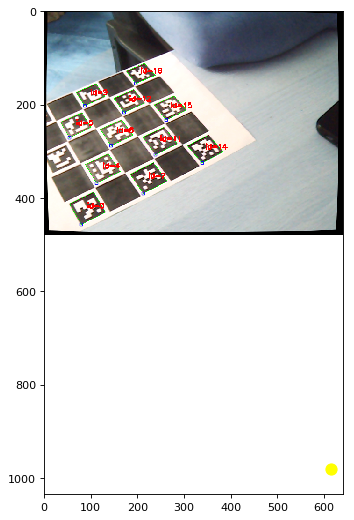

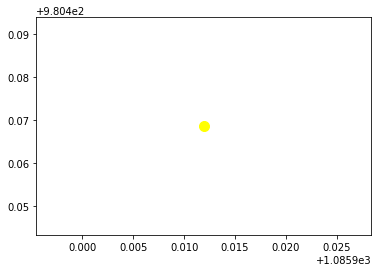

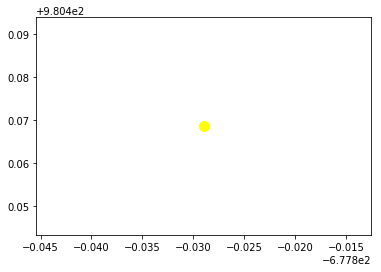

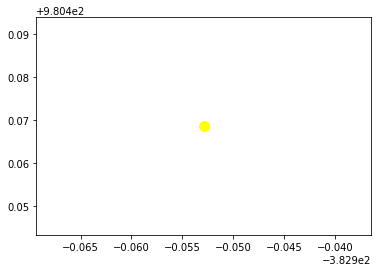

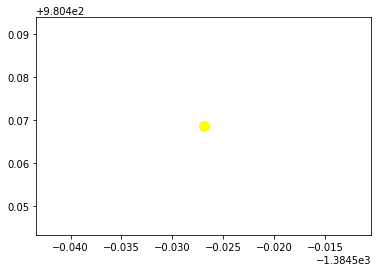

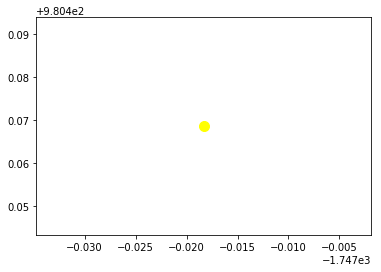

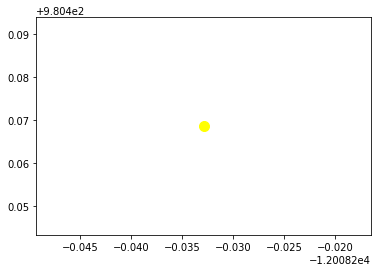

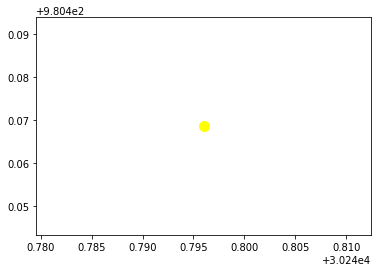

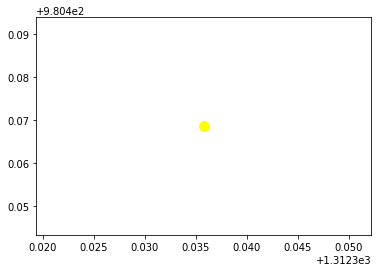

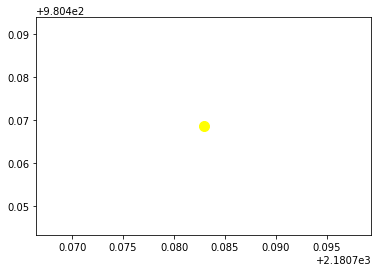

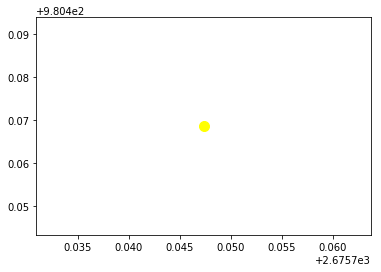

In [14]:
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(frame_markers, interpolation = "nearest")
for i in range(11):
    
    x_3d =np.array([[d[i][0][0]],[d[i][1][0]],[d[i][1][0]]])
    #print(x_3d) # - 3d координаты
    
    #print(mtx)
    x_2d = np.matmul(mtx,x_3d)
    #print(x_2d)
    
    x0 = x_2d[0]/x_2d[2]
    y0 = x_2d[1]/x_2d[2]
    plt.scatter(x0, y0, s=100,color = 'yellow') # рисуем точку в месте полученных координат, и она у нас соглась с исходной!
    plt.show()